In [1]:
import os
import json
import tqdm
import argparse

from src.util import *
from src.train import *
from src.evaluate import *

In [2]:
parser = argparse.ArgumentParser(description="TestLoop",
                                        formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("--loop", default="stroll", choices=["stroll", "test"], type=str, dest="loop")
parser.add_argument("--lr", default=2e-4, type=float, dest="lr")
parser.add_argument("--batch_size", default=1, type=int, dest="batch_size")
parser.add_argument("--train_continue", default="on", choices=["on", "off"], type=str, dest="train_continue")
parser.add_argument("--num_epoch", default=100, type=int, dest="num_epoch")
parser.add_argument("--task", default="pose estimation", choices=["pose estimation"], type=str, dest="task")
parser.add_argument("--ny", default=256, type=int, dest="ny")
parser.add_argument("--nx", default=256, type=int, dest="nx")
parser.add_argument("--nch", default=3, type=int, dest="nch")
parser.add_argument("--nker", default=64, type=int, dest="nker")
parser.add_argument("--norm", default='inorm', type=str, dest="norm")
parser.add_argument("--network", default="PoseResNet", choices=["PoseResNet"], type=str, dest="network")
parser.add_argument("--resnet_depth", default=50, choices=[18, 34, 50, 101, 152], type=int, dest="resnet_depth")
parser.add_argument("--joint_weight", default=False, type=bool, dest="joint_weight")
parser.add_argument("--cuda", default="cuda", choices=["cuda", "cuda:0", "cuda:1"], type=str, dest="cuda")
parser.add_argument("--spec", default="all", type=str, dest="spec")

args = parser.parse_args(args=[])
vars = vars(args)

In [3]:
cwd = os.getcwd()
datasets_dir = os.path.join(cwd, "datasets")
test_report_dir = os.path.join(cwd, "test_results")
test_design_list = os.listdir(datasets_dir)

In [4]:
eval_results = {}
for idx_d, design in enumerate(tqdm.tqdm(test_design_list)):
    setups_dir = os.path.join(datasets_dir, design)
    reports_dir = os.path.join(test_report_dir, design)

    setups_list = os.listdir(setups_dir)
    for idx_s, setup in enumerate(setups_list):
        # Set arguments for evaluation
        vars["mode"] = "test"

        test_data_dir = os.path.join(setups_dir, setup)
        vars["data_dir"] = test_data_dir

        with open(os.path.join(test_data_dir, "test", "labels", "mpii_style.json"), "r", encoding="utf-8") as fread:
            labels_dict = json.load(fread)
            num_mark = len(labels_dict[0]["joints_vis"])
        vars["num_mark"] = num_mark

        args.ckpt_dir = os.path.join(reports_dir, setup, "checkpoint")

        # Evaluate
        evals = evaluate(args=args)
        eval_results["%s" % design+"-"+setup] = evals

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:00<00:00, 120.32s/it]


In [5]:
save_dir = os.path.join(test_report_dir, "evaluation_test_dataset.json")
with open(save_dir, "w", encoding = "UTF-8-SIG") as file:
    json.dump(eval_results, file, ensure_ascii=False)

In [7]:
avg_acc_array = np.zeros((4, len(evals)))

In [9]:
for i, (key, result) in enumerate(tqdm.tqdm(eval_results.items())):
    for j, snip in enumerate(result):
        avg_acc = snip["avg_acc"]
        avg_acc_array[i, j] = avg_acc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 999.71it/s]


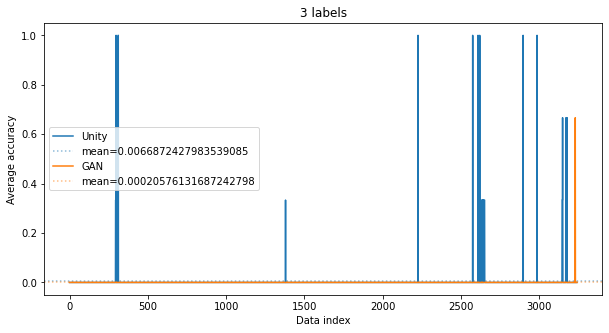

In [32]:
import matplotlib.pyplot as plt

x = np.array(list(range(len(evals))))

unity_mean = np.mean(avg_acc_array[1,:])
gan_mean = np.mean(avg_acc_array[0,:])

plt.figure(figsize=(10, 5))
plt.title("3 labels")
plt.plot(x, avg_acc_array[1,:], color="tab:blue", label="Unity")
plt.axhline(y=unity_mean, color="tab:blue", alpha=0.5, linestyle="dotted", label=f"mean={unity_mean}")
plt.plot(x, avg_acc_array[0,:], color="tab:orange", label="GAN")
plt.axhline(y=gan_mean, color="tab:orange", alpha=0.5, linestyle="dotted", label=f"mean={gan_mean}")
plt.xlabel('Data index')
plt.ylabel('Average accuracy')
plt.legend()
plt.show()

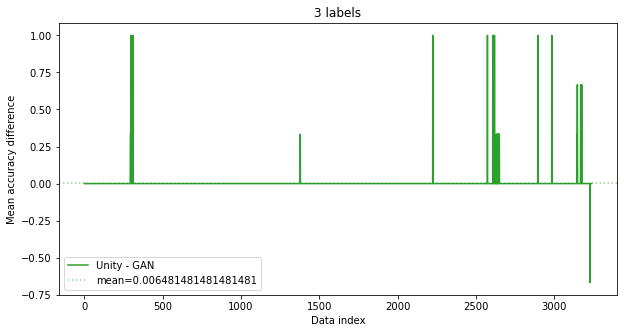

In [33]:
difference = avg_acc_array[1,:] - avg_acc_array[0,:]
mean_diff = np.mean(difference)

plt.figure(figsize=(10, 5))
plt.title("3 labels")
plt.plot(x, difference, color="tab:green", label="Unity - GAN")
plt.axhline(y=mean_diff, color="tab:green", alpha=0.5, linestyle="dotted", label=f"mean={mean_diff}")
plt.xlabel('Data index')
plt.ylabel('Mean accuracy difference')
plt.legend()
plt.show()

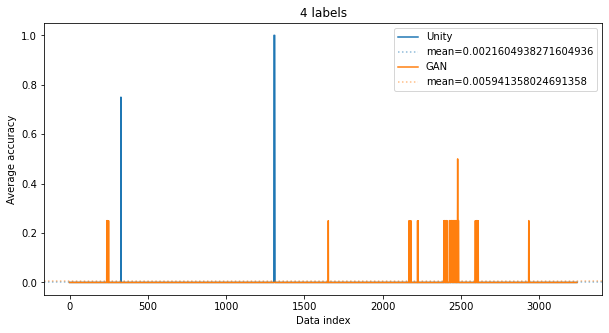

In [34]:
unity_mean = np.mean(avg_acc_array[3,:])
gan_mean = np.mean(avg_acc_array[2,:])

plt.figure(figsize=(10, 5))
plt.title("4 labels")
plt.plot(x, avg_acc_array[3,:], color="tab:blue", label="Unity")
plt.axhline(y=unity_mean, color="tab:blue", alpha=0.5, linestyle="dotted", label=f"mean={unity_mean}")
plt.plot(x, avg_acc_array[2,:], color="tab:orange", label="GAN")
plt.axhline(y=gan_mean, color="tab:orange", alpha=0.5, linestyle="dotted", label=f"mean={gan_mean}")
plt.xlabel('Data index')
plt.ylabel('Average accuracy')
plt.legend()
plt.show()

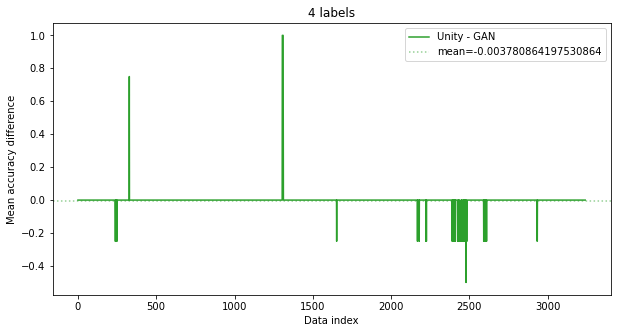

In [35]:
difference = avg_acc_array[3,:] - avg_acc_array[2,:]
mean_diff = np.mean(difference)

plt.figure(figsize=(10, 5))
plt.title("4 labels")
plt.plot(x, difference, color="tab:green", label="Unity - GAN")
plt.axhline(y=mean_diff, color="tab:green", alpha=0.5, linestyle="dotted", label=f"mean={mean_diff}")
plt.xlabel('Data index')
plt.ylabel('Mean accuracy difference')
plt.legend()
plt.show()